# FCN検討ノート

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L

%reload_ext autoreload
%autoreload 2

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'fcn', 'lib'))
from config import *
from fcn import *
from image import *

In [3]:
with open(os.path.join('..', 'cache', 'cv_catalog.json'), 'r') as fp:
    catalog = json.load(fp)

dataset = catalog['dataset']
len(dataset)

150

## 順伝播を実行

In [4]:
model = Fcn()

In [5]:
images = [Image(item['color_image_path'], INPUT_SIZE).image for item in dataset[0:5]]

batch_size = len(images)

In [6]:
xs = chainer.Variable(np.asarray(images).transpose(0,3,1,2).astype(np.float32) / 255.)
xs.shape

(5, 3, 224, 224)

In [7]:
h, h16, h32 = model.forward(xs)

In [8]:
h.shape, h16.shape, h32.shape

((5, 26, 224, 224), (5, 26, 224, 224), (5, 26, 224, 224))

In [9]:
np.argmax(h.data, axis=1)

array([[[22, 19,  6, ..., 16, 25,  8],
        [14,  4, 11, ...,  1, 25, 14],
        [ 5, 17, 11, ..., 21, 19, 14],
        ..., 
        [ 1, 13,  4, ...,  8, 20, 25],
        [ 6, 25, 14, ..., 13,  3,  2],
        [22,  1,  2, ..., 13,  3,  8]],

       [[22, 19,  6, ..., 16, 25,  8],
        [14,  4, 11, ...,  1, 25, 14],
        [ 5, 16, 11, ..., 21, 19, 14],
        ..., 
        [ 1,  9,  8, ...,  8, 20, 25],
        [ 6, 25, 14, ..., 13,  3,  2],
        [22,  1, 11, ..., 13,  3,  8]],

       [[22, 19,  6, ..., 16, 25,  8],
        [14,  4, 11, ...,  1, 25, 14],
        [ 5, 16, 11, ..., 21, 19, 14],
        ..., 
        [19, 13, 22, ...,  8, 18, 25],
        [ 0, 25, 14, ..., 13,  3,  2],
        [22,  1, 11, ..., 13,  3,  8]],

       [[22,  7,  6, ..., 16, 23,  8],
        [14,  4, 11, ...,  1, 25, 14],
        [ 5, 17, 11, ..., 21, 19, 14],
        ..., 
        [ 1, 13,  4, ...,  8, 20, 25],
        [ 6, 25, 14, ..., 13,  3,  2],
        [22,  1, 11, ..., 13,  3,  8]],



## 教師データの作成

In [10]:
label_image = Image(dataset[0]['label_image_path'], INPUT_SIZE).image

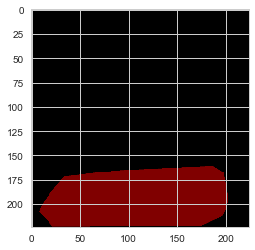

In [11]:
plt.imshow(cv2.cvtColor(label_image, cv2.COLOR_BGR2RGB))

In [12]:
label_images = [Image(item['label_image_path'], INPUT_SIZE).image for item in dataset[0:5]]

In [13]:
labels = [indexed_label_image(image) for image in label_images]

In [14]:
labels[0].shape

(224, 224)

In [15]:
labels[0].max()

1

## 学習を実行

In [16]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [17]:
ts = chainer.Variable(np.asarray(labels).astype(np.int32))
ts.shape

(5, 224, 224)

In [18]:
model.train = True
optimizer.update(model, xs, ts)

In [19]:
model.pixel_acc

0.025824169739654276

In [20]:
indexed_images = np.argmax(h.data, axis=1)
indexed_images.shape

(5, 224, 224)

In [21]:
pred_images = color_label_image(indexed_images)
pred_images.shape

(5, 224, 224, 3)

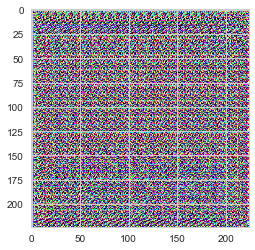

In [22]:
plt.imshow(pred_images[0])

In [23]:
pred_images[0].shape

(224, 224, 3)

## 学習済みモデルをロード

In [25]:
path = os.path.join('..', 'cmd', 'fcn', 'snapshot_2017-04-23_060714', 'final.model')

model = Fcn()
if os.path.exists(path):
    print('load model: %s' % path)
    chainer.serializers.load_npz(path, model)
model.train = False

load model: ../cmd/fcn/snapshot_2017-04-23_060714/final.model


In [26]:
pred_images = model.inference(xs)

In [27]:
pred_images = color_label_image(pred_images)

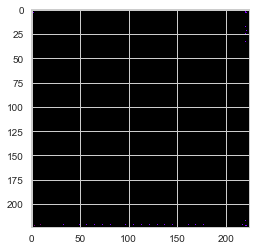

In [28]:
plt.imshow(pred_images[0])